In [2]:
# install dependencies: Zarr, Dask ML
!pip install -q zarr "dask-ml[complete]"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 14.6 MB/s eta 0:00:00


In [3]:
# import everythin and authenticate to Cloud Storage
import gcsfs
import xarray as xr
import zarr
from dask.distributed import Client, progress
import dask_ml.cluster
import matplotlib.pyplot as plt

import google.auth
from google.colab import auth
auth.authenticate_user()

In [4]:
ds = xr.open_zarr('gs://imax-conus/composite-10m/')

bbox = [-74.09972442,  40.0838885 , -74.02481765,  40.12451048] # 500m buffer

ds_small = ds.sel(
    lat=slice(bbox[1], bbox[3]),
    lon=slice(bbox[0], bbox[2]),
    time='2022-01-01'
)

ds_small

<xarray.Dataset> Size: 18MB
Dimensions:  (lon: 841, lat: 456)
Coordinates:
  * lat      (lat) float64 4kB 40.08 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon      (lon) float64 7kB -74.1 -74.1 -74.1 -74.1 ... -74.03 -74.02 -74.02
    time     datetime64[ns] 8B 2022-01-01
Data variables:
    B1       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B11      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B12      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B2       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B3       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B4       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B5       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B6       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B7       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B8       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B8A      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B9       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [ ]:
f"{ds.nbytes / 1e9 :.1f}GB"

'8769.2GB'

In [ ]:
#@title Re-create the Manasquan GeoDataFrame

import pandas as pd
import geopandas as gpd
import shapely

# Data for the GeoDataFrame
data = {
    'class': [1, 1, 1, 1, 1, 1,
              2, 2, 2, 2, 2, 2, 2,
              3, 3, 3, 3, 3, 3],
    'lon': [-74.072227, -74.071670, -74.073687, -74.033947, -74.038196, -74.033775,
            -74.075832, -74.062443, -74.093857, -74.045792, -74.030685, -74.040127, -74.038239,
            -74.060683, -74.044890, -74.069695, -74.061198, -74.041157, -74.060726],
    'lat': [40.093351, 40.090823, 40.088393, 40.104939, 40.106449, 40.099654,
            40.091909, 40.095192, 40.107797, 40.106616, 40.096768, 40.097162, 40.120006,
            40.101000, 40.095780, 40.105694, 40.111175, 40.114096, 40.113801]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the geometry column
df['geometry'] = df.apply(lambda row: shapely.geometry.Point(row['lon'], row['lat']), axis=1)

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the coordinate reference system (optional, but recommended)
gdf.crs = 'EPSG:4326'  # Assuming WGS 84

#@title Buffer the GeoDataFrame's BBOX 500 meters and crop the Zarr to that BBOX

def buffer_bounding_box(gdf, buffer_distance_meters):
    """
    Calculates and buffers the bounding box of a GeoDataFrame in EPSG:4326.

    Args:
        gdf: The GeoDataFrame in EPSG:4326.
        buffer_distance_meters: The buffer distance in meters.

    Returns:
        The buffered bounding box as a GeoDataFrame.
    """

    # Ensure the GeoDataFrame is in EPSG:4326
    if gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')

    # Get the bounding box
    bbox = gdf.total_bounds

    # Extract coordinates from bounds
    xmin, ymin, xmax, ymax = bbox

    # Create a Polygon from the coordinates
    polygon = shapely.geometry.Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

    # Create a GeoSeries from the Polygon
    polygon_gdf = gpd.GeoSeries([polygon], crs='EPSG:4326')

    # Project to a metric CRS for buffering
    bbox_poly_utm = polygon_gdf.to_crs(gdf.estimate_utm_crs())

    # Buffer the polygon
    buffered_bbox_utm = bbox_poly_utm.buffer(buffer_distance_meters)

    # Project back to EPSG:4326
    buffered_bbox = buffered_bbox_utm.to_crs('EPSG:4326')

    return buffered_bbox

# Assuming you have your GeoDataFrame 'gdf' defined

buffered_bbox_gdf = buffer_bounding_box(gdf, 500)

bbox = buffered_bbox_gdf.total_bounds

cropped_ds = ds.sel(
    lat=slice(bbox[1], bbox[3]),
    lon=slice(bbox[0], bbox[2])
)
bbox

array([-74.09972442,  40.0838885 , -74.02481765,  40.12451048])

In [ ]:
bbox = [-74.09972442,  40.0838885 , -74.02481765,  40.12451048] # 500m buffer
# bbox = [-74.10559185,  40.07938399, -74.0189503 ,  40.12901495] # 1000m buffer
# bbox = [-74.11732672,  40.07037497, -74.00721562,  40.13802388] # 2000m buffer
# bbox = [-74.15253146,  40.04334781, -73.97201174,  40.1650506 ] # 5000m buffer

ds_small = ds.sel(
    lat=slice(bbox[1], bbox[3]),
    lon=slice(bbox[0], bbox[2]),
    time='2022-01-01'
)

ds_small

<xarray.Dataset> Size: 18MB
Dimensions:  (lon: 841, lat: 456)
Coordinates:
  * lat      (lat) float64 4kB 40.08 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon      (lon) float64 7kB -74.1 -74.1 -74.1 -74.1 ... -74.03 -74.02 -74.02
    time     datetime64[ns] 8B 2022-01-01
Data variables:
    B1       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B11      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B12      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B2       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B3       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B4       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B5       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B6       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B7       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B8       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B8A      (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
    B9       (lon, lat) float32 2MB dask.array<chunksize=(841, 456), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [ ]:
f'{ds_small.nbytes / 1e9:.4f}GB'

'0.0184GB'

In [ ]:
da = ds_small.to_array()

# stack lat and lon dimensions and transpose as KMeans expects input with a shape: (example, feature)
da = da.stack(point=['lat', 'lon']).transpose()
da

<xarray.DataArray (point: 383496, variable: 12)> Size: 18MB
dask.array<transpose, shape=(383496, 12), dtype=float32, chunksize=(383496, 1), chunktype=numpy.ndarray>
Coordinates:
    time      datetime64[ns] 8B 2022-01-01
  * variable  (variable) object 96B 'B1' 'B11' 'B12' 'B2' ... 'B8' 'B8A' 'B9'
  * point     (point) object 3MB MultiIndex
  * lat       (point) float64 3MB 40.08 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon       (point) float64 3MB -74.1 -74.1 -74.1 ... -74.03 -74.02 -74.02
Attributes:
    crs:      EPSG:4326

In [ ]:
# da = da.fillna(0)

In [ ]:
# start local Dask cluster with 1 worker and 4 threads per worker
client = Client(processes=False, threads_per_worker=4, n_workers=1, memory_limit='12GB')
client

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37493 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/258/20
INFO:distributed.scheduler:  dashboard at:  http://172.28.0.12:37493/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/258/23
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:42959
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/258/20
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          4
INFO:distributed.wo

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.12:37493/status,
Dashboard: http://172.28.0.12:37493/status,Workers: 1
Total threads: 4,Total memory: 11.18 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.12/258/20,Workers: 1
Dashboard: http://172.28.0.12:37493/status,Total threads: 4
Started: Just now,Total memory: 11.18 GiB
Comm: inproc://172.28.0.12/258/23,Total threads: 4
Dashboard: http://172.28.0.12:42959/status,Memory: 11.18 GiB
Nanny: None,


In [ ]:
%%time
km = dask_ml.cluster.KMeans(n_clusters=10, init_max_iter=2, oversampling_factor=10)
km.fit(da)

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3357: UserWarning: Sending large graph

CPU times: user 55.4 s, sys: 2.07 s, total: 57.5 s
Wall time: 53.6 s


KMeans(init_max_iter=2, n_clusters=10, oversampling_factor=10)

In [ ]:
da['predicted_class'] = ('point', km.labels_)

# Unstack the data to restore the original lat/lon dimensions
da = da.unstack('point')
da

<xarray.DataArray (variable: 12, lat: 456, lon: 841)> Size: 18MB
dask.array<reshape, shape=(12, 456, 841), dtype=float32, chunksize=(1, 456, 841), chunktype=numpy.ndarray>
Coordinates:
  * lat              (lat) float64 4kB 40.08 40.08 40.08 ... 40.12 40.12 40.12
  * lon              (lon) float64 7kB -74.1 -74.1 -74.1 ... -74.02 -74.02
    time             datetime64[ns] 8B 2022-01-01
  * variable         (variable) object 96B 'B1' 'B11' 'B12' ... 'B8' 'B8A' 'B9'
    predicted_class  (lat, lon) int32 2MB dask.array<chunksize=(228, 841), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

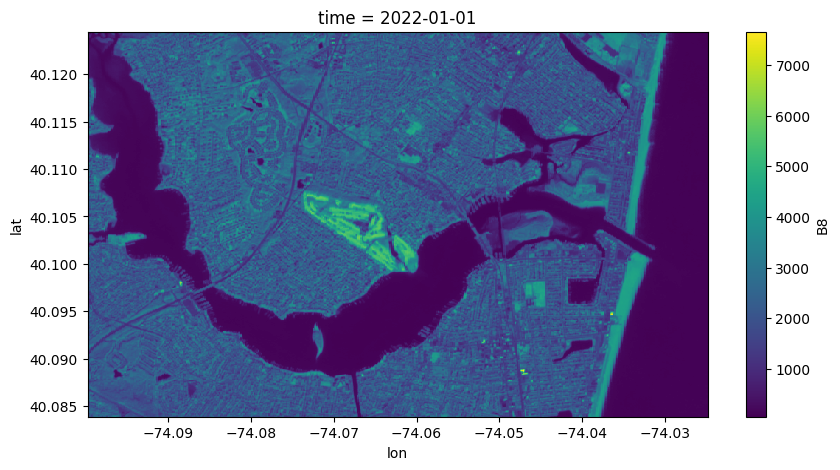

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ds_small.B8.plot(x='lon',y='lat')

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 17.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


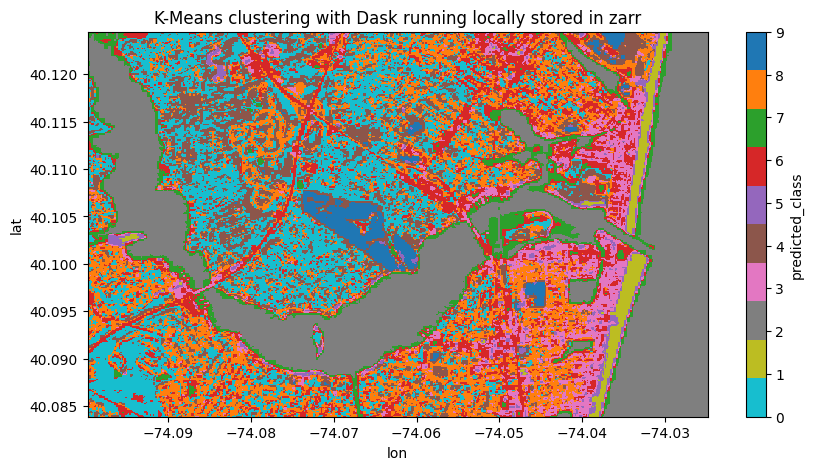

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
da.predicted_class.plot(ax=ax, add_colorbar=True, x='lon', y='lat', cmap='tab10_r')
ax.set_title("K-Means clustering with Dask running locally stored in zarr")
plt.show()

In [ ]:
client.shutdown()